# Jupyter Notebook to train the model

## Importing the dependencies

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import os


In [3]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu') # Move to the GPU
device

device(type='mps')

## Importing the dataset

In [4]:
classes = ['happy', 'sad', 'neutral']
start_path = 'Dataset/train/'
X_train = []
y_train = []


for i in range(len(classes)):
    path = os.path.join(start_path, classes[i])
    for img in os.listdir(path):
        img_array = cv2.imread(os.path
        .join(path, img), cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img_array, (48, 48))

        X_train.append(img_array)
        y_train.append(i)


X_test = []
y_test = []

start_path = 'Dataset/test/'
for i in range(len(classes)):
    path = os.path.join(start_path, classes[i])
    for img in os.listdir(path):
        img_array = cv2.imread(os.path
        .join(path, img), cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img_array, (48, 48))

        X_test.append(img_array)
        y_test.append(i)


X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)




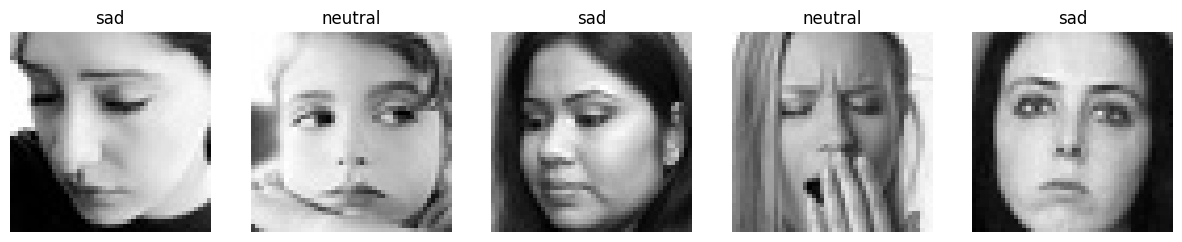

In [5]:
import random

# Select 5 random indices
random_indices = random.sample(range(len(X_train)), 5)

# Plot the images in a grid
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for ax, idx in zip(axes, random_indices):
    ax.imshow(X_train[idx], cmap='gray')
    ax.set_title(classes[y_train[idx]])
    ax.axis('off')
plt.show()

In [6]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Defining the model

In [28]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128*6*6, 512)
        self.fc2 = nn.Linear(512, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 128*6*6)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
from tqdm import tqdm

# Initialize lists to store loss and accuracy
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(25):  # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0
    total = 0

    # Use tqdm to add a progress bar
    model.train()
    for i, data in enumerate(tqdm(train, desc=f"Epoch {epoch+1}"), 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.unsqueeze(1).to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Record the loss
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate and store average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation phase
    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in test:
            inputs, labels = data
            inputs, labels = inputs.unsqueeze(1).to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_running_loss / len(test)
    test_accuracy = 100 * test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Val Loss: {test_loss:.4f}, Val Accuracy: {test_accuracy:.2f}%")

print('Finished Training')

Epoch 1: 100%|██████████| 532/532 [00:07<00:00, 68.58it/s]


Epoch 1, Loss: 1.2967, Accuracy: 42.71%, Val Loss: 1.0855, Val Accuracy: 41.82%


Epoch 2: 100%|██████████| 532/532 [00:07<00:00, 73.65it/s]


Epoch 2, Loss: 1.0776, Accuracy: 42.67%, Val Loss: 1.0614, Val Accuracy: 43.70%


Epoch 3: 100%|██████████| 532/532 [00:07<00:00, 75.38it/s]


Epoch 3, Loss: 1.0726, Accuracy: 43.50%, Val Loss: 1.0675, Val Accuracy: 42.43%


Epoch 4: 100%|██████████| 532/532 [00:07<00:00, 75.62it/s]


Epoch 4, Loss: 0.9913, Accuracy: 49.20%, Val Loss: 0.9353, Val Accuracy: 51.50%


Epoch 5: 100%|██████████| 532/532 [00:07<00:00, 74.79it/s]


Epoch 5, Loss: 0.8622, Accuracy: 58.57%, Val Loss: 0.8418, Val Accuracy: 61.07%


Epoch 6: 100%|██████████| 532/532 [00:07<00:00, 75.35it/s]


Epoch 6, Loss: 0.8056, Accuracy: 62.32%, Val Loss: 0.7777, Val Accuracy: 65.26%


Epoch 7: 100%|██████████| 532/532 [00:07<00:00, 75.55it/s]


Epoch 7, Loss: 0.7600, Accuracy: 64.94%, Val Loss: 0.7609, Val Accuracy: 65.82%


Epoch 8: 100%|██████████| 532/532 [00:07<00:00, 75.06it/s]


Epoch 8, Loss: 0.7220, Accuracy: 66.81%, Val Loss: 0.7475, Val Accuracy: 66.13%


Epoch 9: 100%|██████████| 532/532 [00:07<00:00, 75.45it/s]


Epoch 9, Loss: 0.6911, Accuracy: 68.71%, Val Loss: 0.7279, Val Accuracy: 67.70%


Epoch 10: 100%|██████████| 532/532 [00:07<00:00, 74.71it/s]


Epoch 10, Loss: 0.6523, Accuracy: 70.76%, Val Loss: 0.7414, Val Accuracy: 67.23%


Epoch 11: 100%|██████████| 532/532 [00:07<00:00, 74.46it/s]


Epoch 11, Loss: 0.6117, Accuracy: 73.24%, Val Loss: 0.7811, Val Accuracy: 67.18%


Epoch 12: 100%|██████████| 532/532 [00:07<00:00, 75.51it/s]


Epoch 12, Loss: 0.5740, Accuracy: 75.20%, Val Loss: 0.8268, Val Accuracy: 67.65%


Epoch 13: 100%|██████████| 532/532 [00:07<00:00, 75.44it/s]


Epoch 13, Loss: 0.5372, Accuracy: 76.77%, Val Loss: 0.8434, Val Accuracy: 68.15%


Epoch 14: 100%|██████████| 532/532 [00:07<00:00, 74.75it/s]


Epoch 14, Loss: 0.4829, Accuracy: 79.62%, Val Loss: 0.8705, Val Accuracy: 67.51%


Epoch 15: 100%|██████████| 532/532 [00:07<00:00, 74.41it/s]


Epoch 15, Loss: 0.4343, Accuracy: 81.83%, Val Loss: 0.9548, Val Accuracy: 67.09%


Epoch 16: 100%|██████████| 532/532 [00:07<00:00, 74.56it/s]


Epoch 16, Loss: 0.4037, Accuracy: 83.27%, Val Loss: 1.0103, Val Accuracy: 67.65%


Epoch 17: 100%|██████████| 532/532 [00:07<00:00, 74.91it/s]


Epoch 17, Loss: 0.3796, Accuracy: 84.58%, Val Loss: 1.0420, Val Accuracy: 68.24%


Epoch 18: 100%|██████████| 532/532 [00:07<00:00, 75.19it/s]


Epoch 18, Loss: 0.3540, Accuracy: 85.91%, Val Loss: 1.1420, Val Accuracy: 67.37%


Epoch 19: 100%|██████████| 532/532 [00:07<00:00, 75.26it/s]


Epoch 19, Loss: 0.3192, Accuracy: 87.66%, Val Loss: 1.0734, Val Accuracy: 68.24%


Epoch 20: 100%|██████████| 532/532 [00:07<00:00, 74.80it/s]


Epoch 20, Loss: 0.2826, Accuracy: 88.97%, Val Loss: 1.3547, Val Accuracy: 68.48%


Epoch 21: 100%|██████████| 532/532 [00:07<00:00, 75.45it/s]


Epoch 21, Loss: 0.2913, Accuracy: 88.71%, Val Loss: 1.1552, Val Accuracy: 67.58%


Epoch 22: 100%|██████████| 532/532 [00:07<00:00, 75.34it/s]


Epoch 22, Loss: 0.2626, Accuracy: 90.29%, Val Loss: 1.2813, Val Accuracy: 67.89%


Epoch 23: 100%|██████████| 532/532 [00:07<00:00, 74.76it/s]


Epoch 23, Loss: 0.2806, Accuracy: 89.72%, Val Loss: 1.2652, Val Accuracy: 67.42%


Epoch 24: 100%|██████████| 532/532 [00:07<00:00, 73.81it/s]


Epoch 24, Loss: 0.2335, Accuracy: 91.36%, Val Loss: 1.6516, Val Accuracy: 68.03%


Epoch 25: 100%|██████████| 532/532 [00:07<00:00, 74.59it/s]


Epoch 25, Loss: 0.2342, Accuracy: 91.11%, Val Loss: 1.3779, Val Accuracy: 67.47%
Finished Training


In [37]:
torch.save(model.state_dict() ,'CNN_model.pth')

In [39]:
model = CNN()
model.load_state_dict(torch.load('CNN_model.pth'))
model = model.to(device)
model.eval()


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4608, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)